# Import and pre-definitions

In [1]:
import os
MAIN_PATH = r'/home/luis-felipe'
DATA_PATH = os.path.join(MAIN_PATH,'data')
PATH_MODELS = os.path.join(MAIN_PATH,'torch_models')
FIGS_PATH = os.path.join(MAIN_PATH,'results','figs')

In [2]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_default_dtype(torch.float64)
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

True


In [4]:
import sys
sys.path.insert(1, '..')
sys.path.insert(1, '../..')

import models
from utils import measures,metrics
from data_utils import upload_logits,split_data
import post_hoc

# Evaluate logits

In [5]:
DATASET = 'ImageNet'
VAL_SIZE = 0.1 #5000
METRIC = metrics.AURC
NUM_EXPERIMENTS = 10

In [6]:
methods = {'MSP':measures.MSP,
           'SoftmaxMargin': measures.margin_softmax,
           #'Energy': lambda x:torch.logsumexp(x,-1),
           'MaxLogit':measures.max_logit,
           'LogitsMargin':measures.margin_logits,
           'NegativeEntropy':measures.negative_entropy,
           'NegativeGini': measures.negative_gini}

optm_metrics = {'naurc': metrics.N_AURC,'aurc':metrics.AURC,'auroc':metrics.AUROC,'sac':lambda x,y: metrics.SAC(x,y,0.98), 'ece': metrics.ECE(15)}
transforms = ['raw','T_nll','T','p',1,2,3,4,5,6,7,8,9]

In [7]:
results = {}
for m in optm_metrics:
    results[m] = {m:{t:defaultdict(list) for t in transforms} for m in methods.keys()}
p_list = {m:defaultdict(list) for m in methods.keys()}
acc = defaultdict(list)

In [8]:
seed = SEED
for i in range(NUM_EXPERIMENTS):
    print(i+1)
    for model_arc in models.list_models(DATASET):
        #print(model_arc)
        with torch.no_grad():
            logits_val,labels_val,logits_test,labels_test = split_data.split_logits(*upload_logits(model_arc,DATASET,PATH_MODELS, 
                                split = 'test', device = dev),VAL_SIZE,seed = seed)

        logits_val = post_hoc.centralize(logits_val)
        logits_test = post_hoc.centralize(logits_test)
        risk_val = measures.wrong_class(logits_val,labels_val).float()
        risk_test = measures.wrong_class(logits_test,labels_test).float()
        acc[model_arc].append(1-risk_test.mean().item())
        
        T_nll = post_hoc.optimize.T_fromloss(logits_val,labels_val,torch.nn.CrossEntropyLoss())
        
        for m,method in methods.items():
            if m == 'MaxLogit' or m == 'LogitsMargin': T_range = [1]
            else: T_range = torch.arange(0.01,2,0.01)
            pT = post_hoc.optimize.p_and_beta(logits_val,risk_val,method,METRIC,T_range=T_range)
            p_list[m][model_arc].append(pT[0].item())
            T = post_hoc.optimize.T(logits_val,risk_val,method,METRIC,T_range = T_range)

            for t in transforms:
                if t == 'T_nll': Z = logits_test.div(T_nll)
                elif t == 'T': Z = logits_test.div(T)
                elif t == 'p': Z = post_hoc.normalize(logits_test,pT[0]).div(pT[1])
                elif isinstance(t,int): 
                    T_p = post_hoc.optimize.p_and_beta(logits_val,risk_val,method,METRIC,p_range = [t],T_range=T_range)[1]
                    Z = post_hoc.normalize(logits_test,t).div(T_p)
                else: Z = logits_test
                for metric in optm_metrics:
                    results[metric][m][t][model_arc].append(optm_metrics[metric](risk_test,method(Z)))
    seed = seed+10

models_list = list(acc.keys())

1
2
3
4
5
6
7
8
9
10


In [9]:
means = {}
std = {}
acc_mean = {}
for metric, d_metric in results.items():
    means[metric] = {}
    std[metric] = {}
    for method, d_method in d_metric.items():
        means[metric][method] = {}
        std[metric][method] = {}
        for transform, d_t in d_method.items():
            means[metric][method][transform] = {}
            std[metric][method][transform] = {}
            for model_arc,v in d_t.items():
                means[metric][method][transform][model_arc] = np.mean(v)
                std[metric][method][transform][model_arc] = np.std(v)
                acc_mean[model_arc] = np.mean(acc[model_arc])

## Figure 13

(0.13, 0.45)

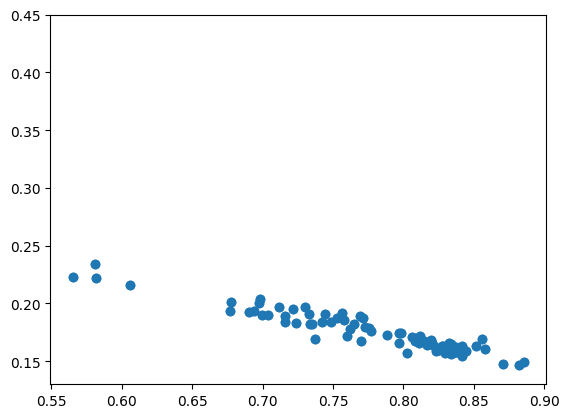

In [10]:
naurc = np.minimum(np.array(list(means['naurc']['MaxLogit']['p'].values())),np.array(list(means['naurc']['MSP']['raw'].values())))
stds = np.minimum(np.array(list(std['naurc']['MaxLogit']['p'].values())),np.array(list(std['naurc']['MSP']['raw'].values())))
plt.scatter(list(acc_mean.values()),naurc)
plt.errorbar(list(acc_mean.values()),naurc, yerr=stds, fmt="o")
plt.ylim(0.13,0.45)

## Figure 2/12

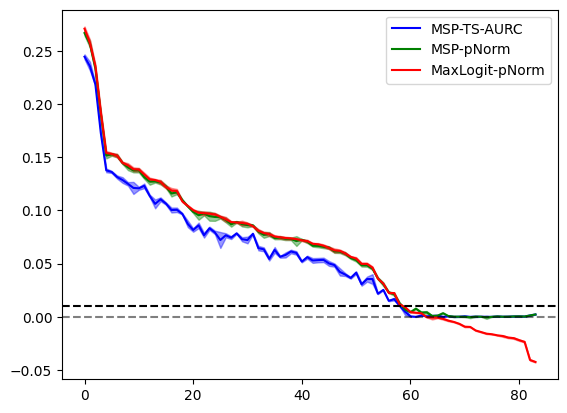

In [11]:
baseline = np.array(list(results['naurc']['MSP']['raw'].values()))
idx = np.argsort(baseline.mean(-1)-np.array(list(means['naurc']['MaxLogit']['p'].values())))[::-1]
methods_plot = {'MSP-TS-AURC':results['naurc']['MSP']['T'],
          'MSP-pNorm':results['naurc']['MSP']['p'],
          'MaxLogit-pNorm':results['naurc']['MaxLogit']['p']}
colors = iter(['blue','green','red'])
for name,values in methods_plot.items():
    values = np.array(list(values.values()))
    gains = baseline-values
    gains_mean = gains.mean(-1)[idx]
    gains_std = gains.std(-1)[idx]
    plot = plt.plot(gains_mean,label = name,color = next(colors))
    plt.fill_between(range(len(models_list)),gains_mean-gains_std,gains_mean+gains_std,alpha = 0.4,color = plot[0].get_color())
plt.axhline(0.01,color = 'k',linestyle = '--')
plt.axhline(0,color = 'k',linestyle = '--',alpha = 0.5)
plt.legend()
plt.show()

In [12]:
d_method.keys()

dict_keys(['raw', 'T_nll', 'T', 'p', 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Table 1

In [13]:
for model_arc,model_name in {'efficientnetv2_xl': 'EfficientNet-V2-XL', 'vgg16':'VGG16'}.items():
    print(r'\midrule \multirow{6}{*}{' + model_name + '}' )
    for method, d_method in results['naurc'].items():
        string = f'& {method}'
        for transform, d_t in d_method.items():
            if 'T' in transform and 'Logit' in method:
                string += f" & -"
            else: string += f" & {np.mean(d_t[model_arc],-1):.4f}"+r' {\footnotesize $\pm$'+f"{np.std(d_t[model_arc],-1):.4f}" + "}"
        print(string + r' \\')
            

\midrule \multirow{6}{*}{EfficientNet-V2-XL}


TypeError: argument of type 'int' is not iterable

## Table 2

In [ ]:
results['naurc']['MaxLogit']['p']

In [ ]:
for method, d_method in results['naurc'].items():
    string = f'{method}'
    for transform, d_t in d_method.items():
        if 'T' in transform and 'Logit' in method:
            string += f" & -"
        elif post_hoc.significant(baseline - np.array(list(d_t.values())),0.01).mean() < 0.00001 and post_hoc.significant(baseline - np.array(list(d_t.values())),0.01).mean(0).std()<0.0001:
            string += r" & 0.0 {\footnotesize $\pm$ 0.0}"
        else: string += f" & {post_hoc.significant(baseline - np.array(list(d_t.values())),0.01).mean():.5f}"+r' {\footnotesize $\pm$'+f"{post_hoc.significant(baseline - np.array(list(d_t.values())),0.01).mean(0).std():.5f}"+"}"
    print(string + r' \\')

In [ ]:
baseline = d_naurc['MSP']
d_optimal = {m:1 for m in models_list}
d_optimal_method = {m:None for m in models_list}
gain = {}
gain_T = {}
gain_T_nll = {}
gain_p = {}
for method in methods:
    gain[method] = np.array(list(baseline.values()))-np.array(list(d_naurc[method].values()))
    gain_T[method] = np.array(list(baseline.values()))-np.array(list(d_naurc_T[method].values()))
    gain_T_nll[method] = np.array(list(baseline.values()))-np.array(list(d_naurc_T_nll[method].values()))
    gain_p[method] = np.array(list(baseline.values()))-np.array(list(d_naurc_p[method].values()))
    for m in models_list:
        for t,d in {'base':d_naurc,'p':d_naurc_p,'T':d_naurc_T,'T_nll':d_naurc_T_nll}.items():
            if d[method][m] < d_optimal[m]:
                d_optimal[m] = d[method][m]
                d_optimal_method[m] = f'{t} - {method}'

gains_opt = np.array(list(baseline.values()))-np.array(list(d_optimal.values()))

In [ ]:
for m,gains in gain_p.items():
    if m == 'Energy':continue
    print(f'{m}, {np.mean(post_hoc.significant(gains, 0.01)):.5f}')

In [ ]:
for m,gains in gain_p.items():
    if m == 'Energy':continue
    print(f'{m}, {np.std(post_hoc.significant(gains, 0.01)):.5f}')

In [ ]:
plt.scatter(norms_l2,gain_p['MaxLogit'])
plt.axhline(0.01,linestyle='--',color='k')
plt.grid()
plt.xlabel('MSP var')
plt.ylabel('MaxLogit-p Gain')

In [ ]:
plt.scatter(np.mean(np.array(msps)>0.999,axis=-1)[gain_p['MaxLogit']>0.01],gain_p['MaxLogit'][gain_p['MaxLogit']>0.01], color = 'r')
plt.scatter(np.mean(np.array(msps)>0.999,axis=-1)[gain_p['MaxLogit']<=0.01],gain_p['MaxLogit'][gain_p['MaxLogit']<=0.01], color = 'b')
#plt.scatter(np.mean(msps>0.999,axis=-1),gain_p['MaxLogit'], c = list(d_naurc['MSP'].values()), cmap = 'coolwarm')
plt.axhline(0.01,linestyle='--',color='k')
plt.grid()
plt.xlabel('Proportion of samples with MSP>0.999')
plt.ylabel('NAURC gain of MaxLogit-pNorm over MSP')
plt.savefig(os.path.join(FIGS_PATH,'msp_proportion_imagenet.pdf'),format = 'pdf')

In [ ]:
args = np.argsort(gain_p['MaxLogit'])[::-1]


for method in ['MSP']:
    if method == 'Energy': continue
    plt.plot(range(1,1+len(models_list)),gain_T_nll[method][args], label = method+'-TS-NLL')
for method in ['LogitsMargin']:
    if method == 'Energy': continue
    plt.plot(range(1,1+len(models_list)),gain[method][args], label = method)
for method in ['MSP']:
    if method == 'Energy': continue
    plt.plot(range(1,1+len(models_list)),gain_T[method][args], label = method+'-TS-AURC')
for method in ['NegativeEntropy','SoftmaxMargin','NegativeGini','MSP','MaxLogit']:
    label = method+'-pNorm'
    if method == 'Energy': continue
    plt.plot(range(1,1+len(models_list)),gain_p[method][args], label = label)
#plt.plot(gain['MaxLogit']*100,gain['MaxLogit']*100,'k--', label = 'MaxLogit')
plt.axhline(0.01,linestyle='--', color = 'k')
plt.legend()
plt.grid()
plt.xlabel('Models')
plt.ylabel('NAURC gain over MSP')
plt.xticks()
plt.savefig(os.path.join(FIGS_PATH,'gains_methods.pdf'),format = 'pdf')
#plt.show()


In [ ]:
#df = pd.DataFrame()
d_efficientnet = {}
m = 'vgg16'
for t,d in {'Raw':d_auroc,'TS-NLL':d_auroc_T_nll,'TS-AURC':d_auroc_T,'p-norm':d_auroc_p}.items():
    d1 = {}
    for method in methods:
        if method == 'Energy': continue
        d1[method] = d[method][m] 
    d_efficientnet[t] = d1

In [ ]:
df = (pd.DataFrame(d_efficientnet))
df

In [ ]:
print(df.to_latex(float_format="{:.4f}".format))

In [ ]:
epsilon_list = np.arange(0,0.05,0.001)
from collections import defaultdict
apgs = defaultdict(list)
for m,gains in gain_p.items():
    if m == 'Energy':continue
    for epsilon in epsilon_list:
        apgs[m].append(np.mean(post_hoc.significant(gains, epsilon)))

In [ ]:
for m,apg in apgs.items():
    if m=='Entropy' or m=='Gini': m='Negative'+m
    plt.plot(epsilon_list,apg, label = m+'-pNorm')
plt.xlabel(r'$\epsilon$')
plt.ylabel('APG-NAURC')
plt.grid()
plt.legend()
plt.savefig(os.path.join(FIGS_PATH,'epsilon.pdf'),format = 'pdf',transparent = True,bbox_inches = 'tight')

In [ ]:
from scipy.stats import spearmanr

In [ ]:
d_optimal_aurc = {m:1 for m in models_list}
d_optimal_method = {m:None for m in models_list}
for method in methods:
    for m in models_list:
        for t,d in {'base':d_aurc,'p':d_aurc_p,'T':d_aurc_T}.items():
            if d[method][m] < d_optimal_aurc[m]:
                d_optimal_aurc[m] = d[method][m]
                d_optimal_method[m] = f'{t} - {method}'
baseline_aurc = d_aurc['MSP']

In [ ]:
fig,axes = plt.subplots(1,2,figsize = (10,4), sharey = True)
fig.tight_layout()
scatter = axes[0].scatter(np.array(list(acc.values())),np.array(list(baseline_aurc.values())),c = list(optimal_p['MaxLogit'].values()))
axes[1].scatter(acc.values(),d_optimal_aurc.values(),c = list(optimal_p['MaxLogit'].values()))
axes[0].set_title(fr'Baseline - $\rho$={spearmanr(np.array(list(acc.values())),np.array(list(baseline_aurc.values()))).correlation:.4f}')
axes[1].set_title(fr'Optimized- $\rho$={spearmanr(np.array(list(acc.values())),np.array(list(d_optimal_aurc.values()))).correlation:.4f}')
axes[0].set_ylabel('AURC')
for ax in axes:
    ax.grid()
    ax.set_xlabel('Accuracy')
#axes[0].legend()
l = scatter.legend_elements()[1]
for n,i in enumerate(l):
    l[n] = 'p = '+i 
l[0] = 'MSP'

legend1 = axes[0].legend(scatter.legend_elements()[0], l)

plt.savefig(os.path.join(FIGS_PATH,'AURC.pdf'), transparent = True, format = 'pdf',bbox_inches = 'tight')
plt.show()

In [ ]:
d_optimal_naurc = {m:1 for m in models_list}
d_optimal_method = {m:None for m in models_list}
for method in methods:
    for m in models_list:
        for t,d in {'base':d_naurc,'p':d_naurc_p,'T':d_naurc_T}.items():
            if d[method][m] < d_optimal_naurc[m]:
                d_optimal_naurc[m] = d[method][m]
                d_optimal_method[m] = f'{t} - {method}'
baseline_naurc = d_naurc['MSP']

In [ ]:
fig,axes = plt.subplots(1,2,figsize = (10,4), sharey = True)
fig.tight_layout()
scatter = axes[0].scatter(np.array(list(acc.values())),np.array(list(baseline_naurc.values())),c = list(optimal_p['MaxLogit'].values()))
axes[1].scatter(acc.values(),d_optimal_naurc.values(),c = list(optimal_p['MaxLogit'].values()))
axes[0].set_title(fr'Baseline - $\rho$={spearmanr(np.array(list(acc.values())),np.array(list(baseline_naurc.values()))).correlation:.4f}')
axes[1].set_title(fr'Optimized- $\rho$={spearmanr(np.array(list(acc.values())),np.array(list(d_optimal_naurc.values()))).correlation:.4f}')
axes[0].set_ylabel('NAURC')
for ax in axes:
    ax.grid()
    ax.set_xlabel('Accuracy')
axes[0].legend()
l = scatter.legend_elements()[1]
for n,i in enumerate(l):
    l[n] = 'p = '+i 
l[0] = 'MSP'
legend1 = axes[0].legend(scatter.legend_elements()[0], l)

plt.savefig(os.path.join(FIGS_PATH,'NAURC.pdf'), transparent = True, format = 'pdf',bbox_inches = 'tight')

In [ ]:
from collections import defaultdict

In [ ]:
d = defaultdict(list)
for model in models_list:
    d[model].append(acc[model])
    d[model].append(d_naurc['MSP'][model])
    d[model].append(d_naurc_T_nll['MSP'][model])
    d[model].append(d_naurc_T['MSP'][model])
    d[model].append(d_naurc['LogitsMargin'][model])
    d[model].append(str(d_naurc_p['MSP'][model])[0:6] +' - ' + str(p_list['MSP'][model]))
    d[model].append(str(d_naurc_p['MaxLogit'][model])[0:6] +' - ' + str(p_list['MaxLogit'][model]))

In [ ]:
df = pd.DataFrame(d).transpose()
df

In [ ]:
print(df.to_latex(float_format="{:.4f}".format))